In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import copy
from scipy import sparse

In [2]:
adata = sc.read_h5ad("/project/single_cell/jpark_internship/data/mouse_brain_atlas/mouse_brain_atlas_sparse_matrix.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 292495 × 31053
    obs: 'Age', 'Batch', 'CellCycle', 'CellCycle_G1', 'CellCycle_G2M', 'CellCycle_S', 'Cell_Conc', 'ChipID', 'Class', 'Clusters', 'ClustersCollected', 'DBId', 'Date_Captured', 'DonorID', 'DoubletFinderPCA', 'HPF_LogPP', 'IsCycling', 'Label', 'NCellsCluster', 'NGenes', 'Num_Pooled_Animals', 'PCR_Cycles', 'Plug_Date', 'PseudoAge', 'PseudoTissue', 'Punchcard', 'PunchcardClusters', 'Region', 'Replicate', 'SampleID', 'SampleName', 'Sample_Index', 'Tissue', 'TotalUMI', 'ngperul_cDNA'

In [11]:
age_map = {}
for age in set(adata.obs['Age']): 
    age_map[age] = float(age[1:])

gene_map = {}
gene_map_r = {}
for gene in adata.var.index:
    gene_map[gene.split("|")[1]] = gene
    gene_map_r[gene] = gene.split("|")[1]

In [12]:
adata_sub = adata[(adata.obs['Age'] == 'e14.5') & 
                  (adata.obs['Tissue'] == 'ForebrainDorsal') & 
                  (adata.obs['Class'].isin(['Radial glia','Neuron'])) &
                  (adata.obs['SampleName']=='G13')]

In [13]:
adata_sub

View of AnnData object with n_obs × n_vars = 2940 × 31053
    obs: 'Age', 'Batch', 'CellCycle', 'CellCycle_G1', 'CellCycle_G2M', 'CellCycle_S', 'Cell_Conc', 'ChipID', 'Class', 'Clusters', 'ClustersCollected', 'DBId', 'Date_Captured', 'DonorID', 'DoubletFinderPCA', 'HPF_LogPP', 'IsCycling', 'Label', 'NCellsCluster', 'NGenes', 'Num_Pooled_Animals', 'PCR_Cycles', 'Plug_Date', 'PseudoAge', 'PseudoTissue', 'Punchcard', 'PunchcardClusters', 'Region', 'Replicate', 'SampleID', 'SampleName', 'Sample_Index', 'Tissue', 'TotalUMI', 'ngperul_cDNA'

In [14]:
sc.pp.filter_genes(adata_sub,min_counts=1)

/project/elkabetz_lab/Daniel/willow/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:249: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


In [15]:
adata_sub

AnnData object with n_obs × n_vars = 2940 × 16202
    obs: 'Age', 'Batch', 'CellCycle', 'CellCycle_G1', 'CellCycle_G2M', 'CellCycle_S', 'Cell_Conc', 'ChipID', 'Class', 'Clusters', 'ClustersCollected', 'DBId', 'Date_Captured', 'DonorID', 'DoubletFinderPCA', 'HPF_LogPP', 'IsCycling', 'Label', 'NCellsCluster', 'NGenes', 'Num_Pooled_Animals', 'PCR_Cycles', 'Plug_Date', 'PseudoAge', 'PseudoTissue', 'Punchcard', 'PunchcardClusters', 'Region', 'Replicate', 'SampleID', 'SampleName', 'Sample_Index', 'Tissue', 'TotalUMI', 'ngperul_cDNA'
    var: 'n_counts'

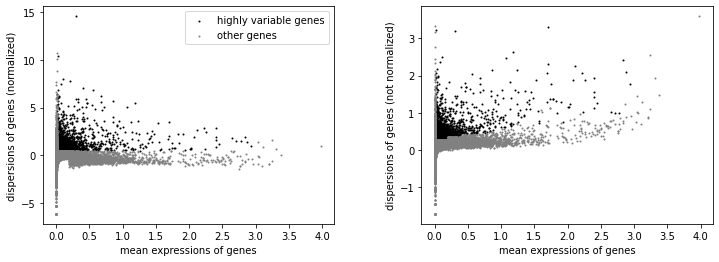

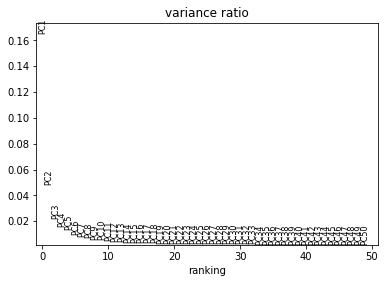

In [16]:
sc.pp.normalize_total(adata_sub,)#, target_sum=1e6)#, inplace=False)
adata_sub.X = np.log1p(adata_sub.X)

sc.pp.highly_variable_genes(adata_sub)#,min_mean = min_mean,min_disp=min_disp,max_mean=max_mean)
sc.pl.highly_variable_genes(adata_sub)

#run PCA
sc.tl.pca(adata_sub, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_sub, log=False, n_pcs=50)

sc.pp.neighbors(adata_sub)
sc.tl.umap(adata_sub)

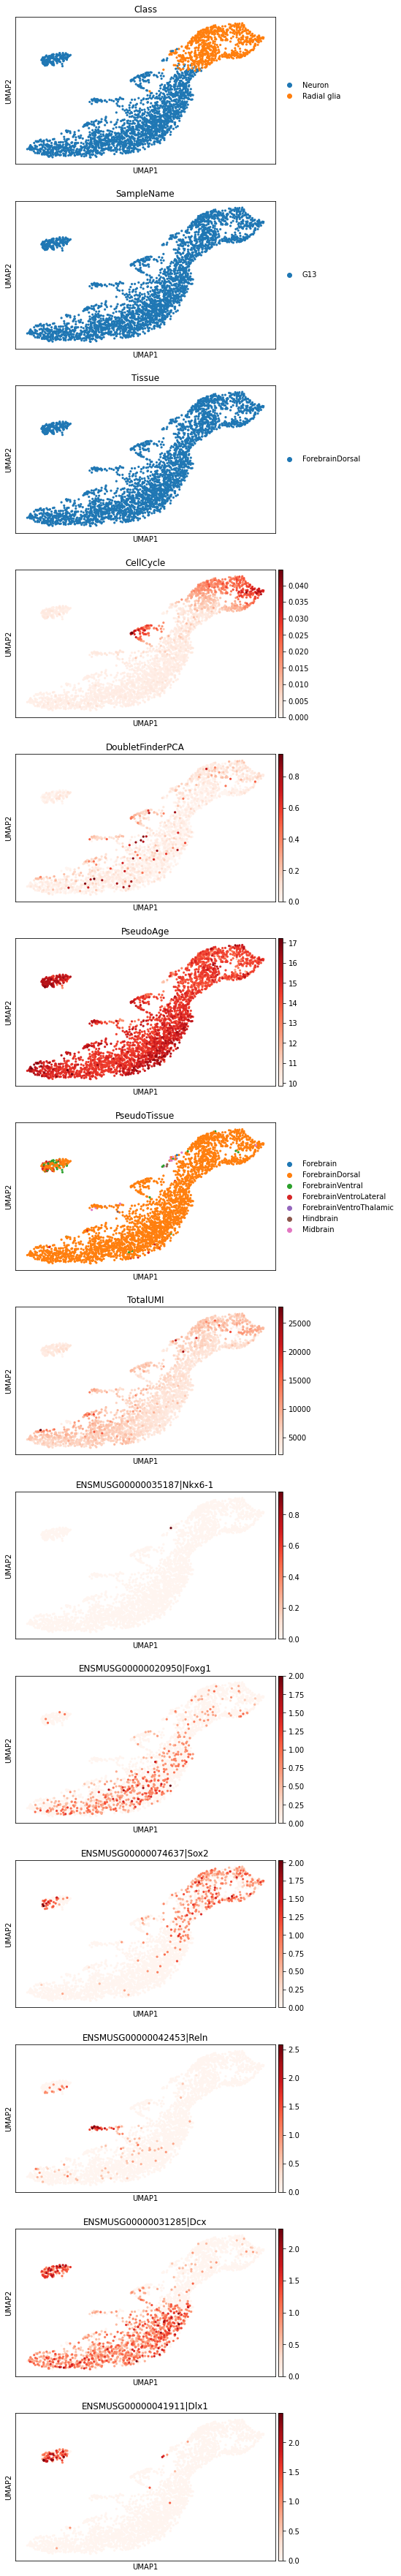

In [23]:
sc.pl.umap(adata_sub,color=['Class','SampleName','Tissue','CellCycle','DoubletFinderPCA','PseudoAge', 'PseudoTissue',
                            'TotalUMI',gene_map['Nkx6-1'],gene_map['Foxg1'],gene_map['Sox2'],gene_map['Reln'],
                            gene_map['Dcx'],gene_map['Dlx1']],
           ncols=1,color_map='Reds')

In [24]:
set(adata_sub.obs[adata_sub.obs['Tissue']=='ForebrainDorsal']['Class'])

{'Neuron', 'Radial glia'}

In [25]:
sc.tl.louvain(adata_sub,resolution=1.5)

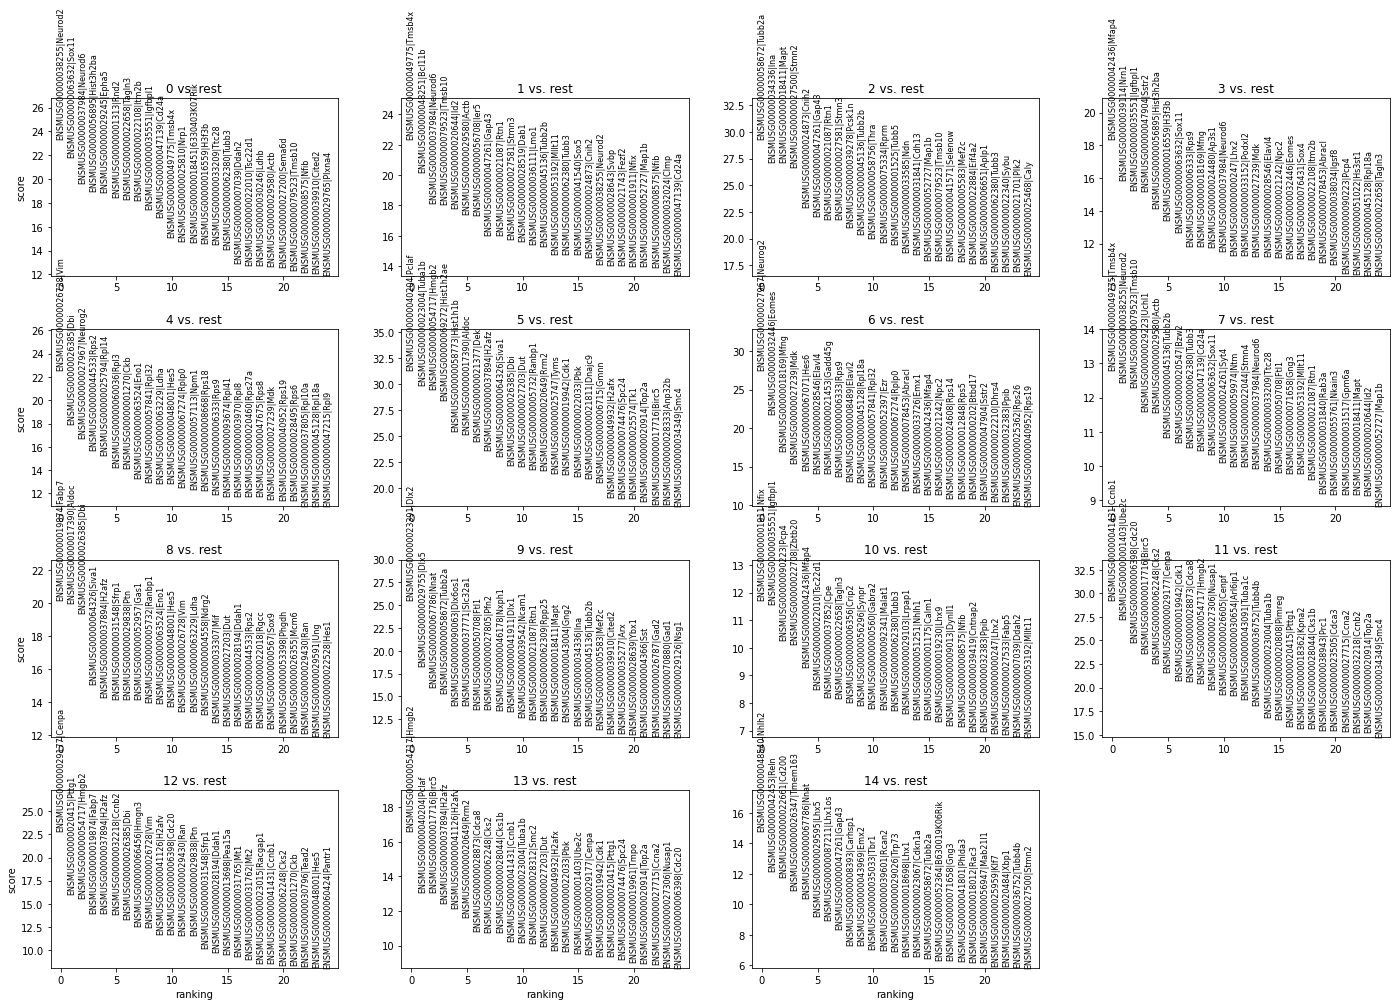

In [26]:
## run marker gene analysis
sc.tl.rank_genes_groups(adata_sub, 'louvain', method='t-test_overestim_var', n_genes=40000)
sc.pl.rank_genes_groups(adata_sub, n_genes=25, sharey=False)

In [27]:
#clusters to filter: 9 - Subpallium, 14,10 - Cajal-Retzius, 5,11,12,13 -- dividing

In [28]:
adata_sub = adata_sub[~(adata_sub.obs['louvain'].isin(['9','10','11','12','13','14','5']))]

In [31]:
adata_sub = adata[adata_sub.obs.index,adata_sub.var.index]

In [35]:
sc.pp.normalize_total(adata_sub,)#, target_sum=1e6)#, inplace=False)
adata_sub.X = np.log1p(adata_sub.X)

/project/elkabetz_lab/Daniel/willow/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


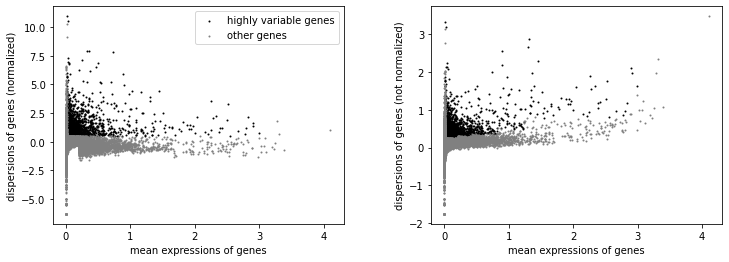

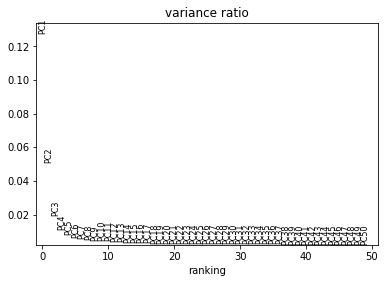

In [36]:
sc.pp.highly_variable_genes(adata_sub)#,min_mean = min_mean,min_disp=min_disp,max_mean=max_mean)
sc.pl.highly_variable_genes(adata_sub)

#run PCA
sc.tl.pca(adata_sub, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_sub, log=False, n_pcs=50)

sc.pp.neighbors(adata_sub)
sc.tl.umap(adata_sub)

In [37]:
sc.tl.louvain(adata_sub,resolution=1)

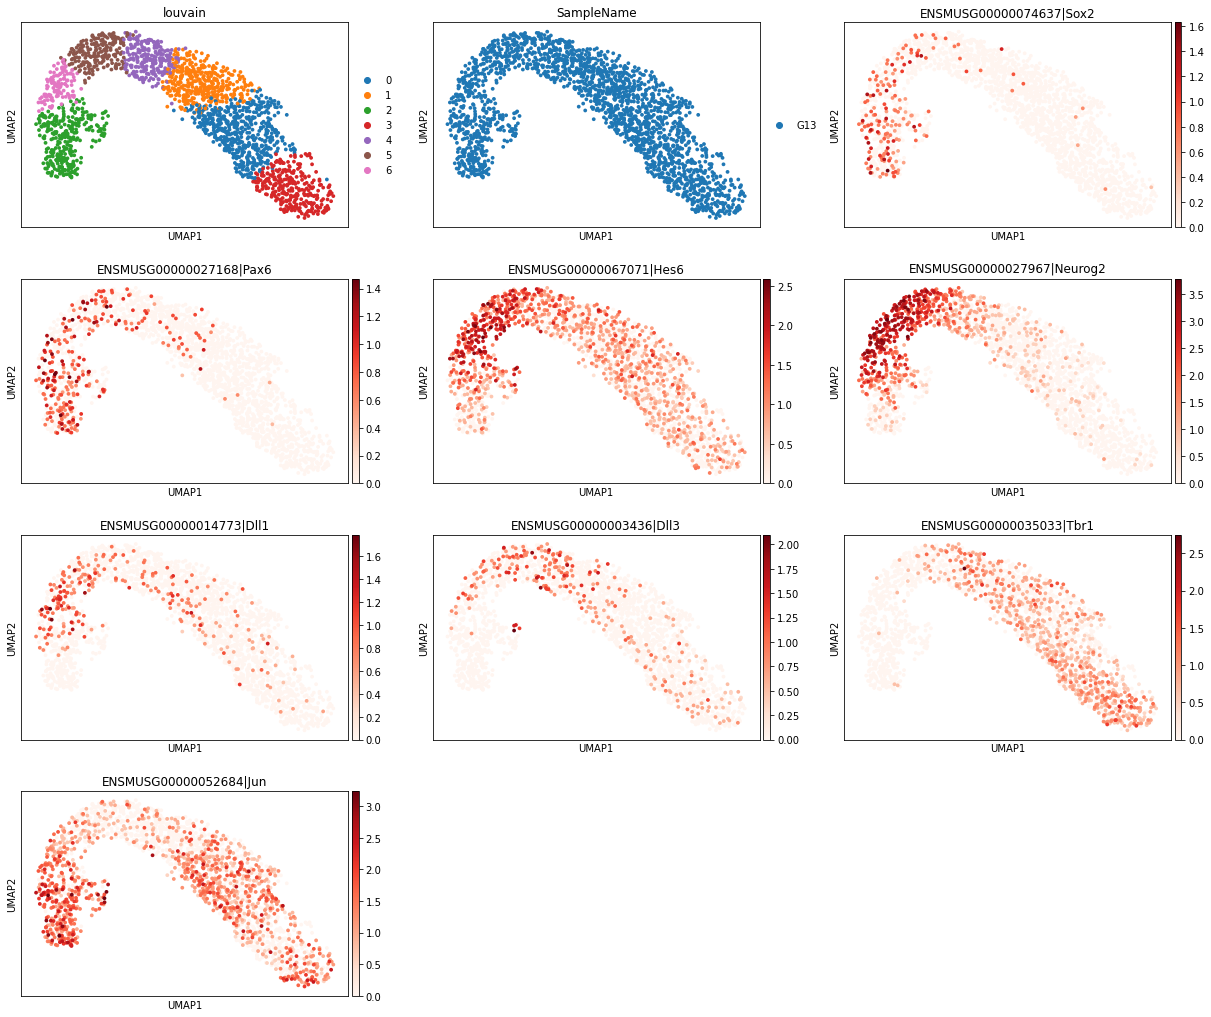

In [39]:
sc.pl.umap(adata_sub,color=['louvain','SampleName',gene_map['Sox2'],gene_map['Pax6'],gene_map['Hes6'],
                            gene_map['Neurog2'],gene_map['Dll1'],gene_map['Dll3'],gene_map['Tbr1'],gene_map['Jun']],
           ncols=3,color_map='Reds')

In [40]:
sc.pp.neighbors(adata_sub,method='gauss',n_neighbors=30)
sc.tl.diffmap(adata_sub)

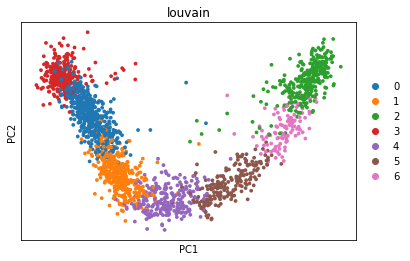

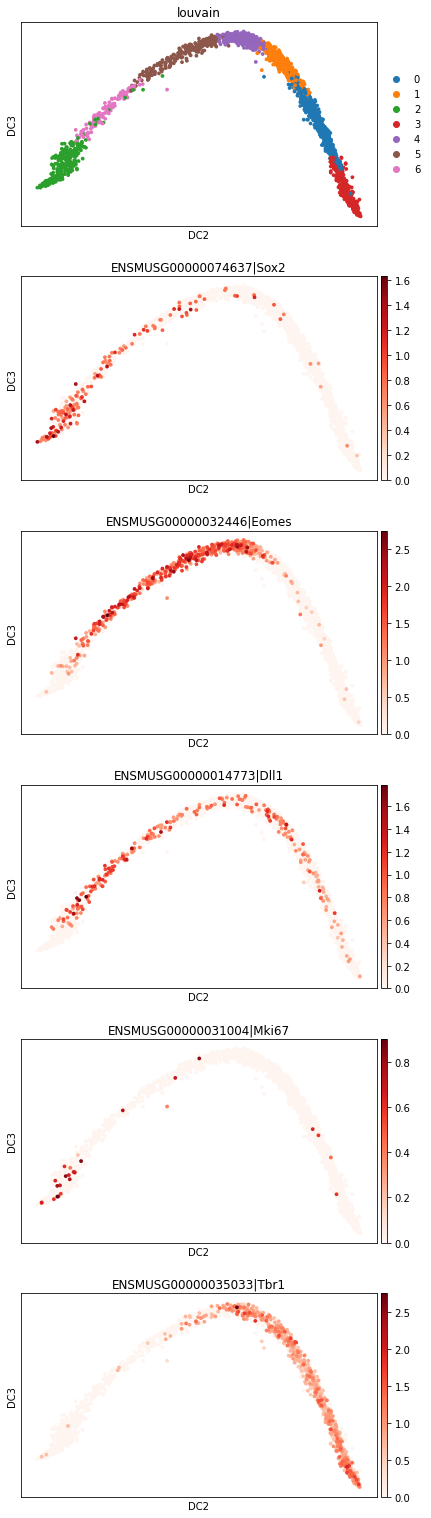

In [68]:
sc.pl.pca(adata_sub,color=['louvain'],color_map='Reds',components='1,2')
sc.pl.diffmap(adata_sub,color=['louvain',gene_map['Sox2'],gene_map['Eomes'],gene_map['Dll1'],gene_map['Mki67'],gene_map['Tbr1']],color_map='Reds',components='2,3',ncols=1)

In [43]:
adata_sub.uns['iroot'] = np.argmin(adata_sub.obsm['X_diffmap'][:,1])

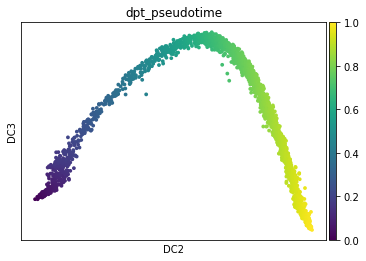

In [44]:
sc.tl.dpt(adata_sub)
sc.pl.diffmap(adata_sub,color=['dpt_pseudotime'],color_map='viridis',components='2,3')

In [45]:
genes = list(adata_sub.var.index)

In [46]:
adata_sub.obs['index'] = range(len(adata_sub.obs))

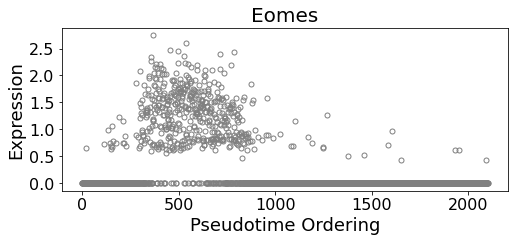

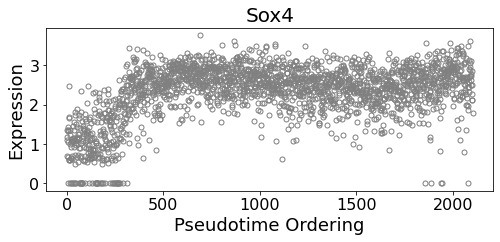

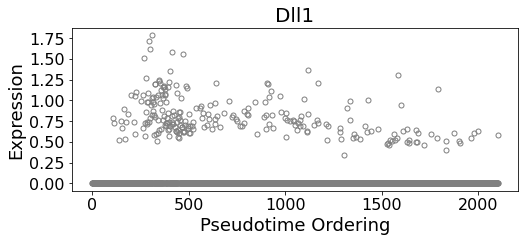

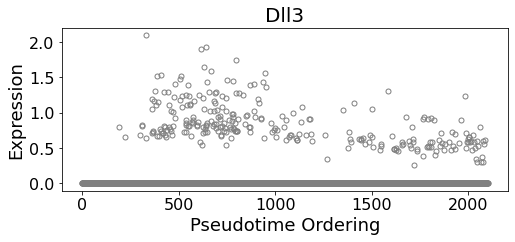

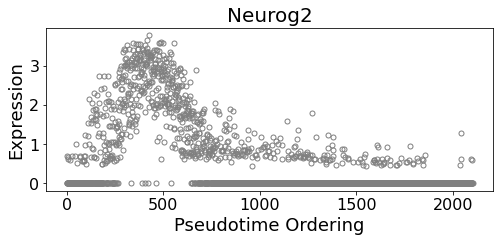

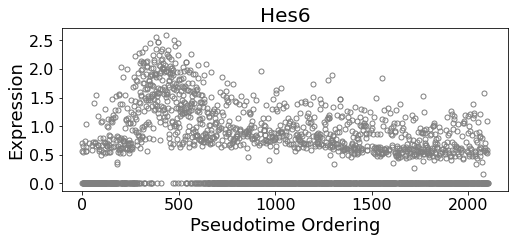

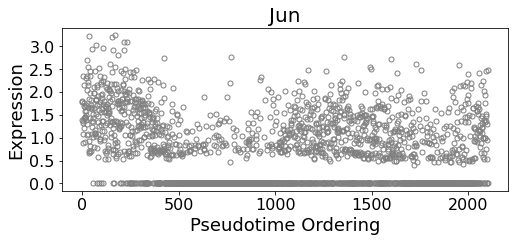

In [47]:
for gene in ['Eomes','Sox4','Dll1','Dll3','Neurog2','Hes6','Jun']:
    ordered_expression = adata_sub[:,gene_map[gene]].X[adata_sub.obs.sort_values(by='dpt_pseudotime')['index']].toarray()
    xdata = range(len(ordered_expression))
    plt.figure(figsize=(8,3))
    plt.plot(xdata, ordered_expression,'.', markerfacecolor='None',color='gray', lw=0.1, markersize=10, alpha=1,zorder=-1)
    plt.title(gene,fontsize=20)
    plt.xlabel('Pseudotime Ordering',fontsize=18)
    plt.ylabel('Expression',fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

In [54]:
genes_sub = list(adata_sub.var.index)
sorted_idx = list(adata_sub.obs.sort_values(by='dpt_pseudotime')['index'])

In [62]:
with open('/project/elkabetz_lab/Daniel/Transcriptional_Cascades/scripts/Transcriptional_Cascades/data/e14_5_mouse_forebrain_neuron_diff.raw_count_matrix.tsv','w') as output:
    output.write('cell_id\t'+'\t'.join(genes_sub)+'\n')
    for expr_row,cell in zip(adata[adata_sub.obs.loc[adata_sub.obs['index'][sorted_idx].index].index,genes_sub].X.toarray(),
                             adata_sub.obs['index'][sorted_idx].index):
        output.write(cell+'\t'+'\t'.join([str(int(x)) for x in expr_row])+'\n')
output.close()

In [63]:
counts_dict = {}
genes = []
with open('/project/elkabetz_lab/Daniel/Transcriptional_Cascades/scripts/Transcriptional_Cascades/data/e14_5_mouse_forebrain_neuron_diff.raw_count_matrix.tsv','r') as expr_mat_fn:
    for i,row in enumerate(expr_mat_fn):
        spl = row.strip("\n").split("\t")
        if i == 0:
            for j in range(1,len(spl)):
                counts_dict[spl[j]] = []
                genes.append(spl[j])
        else:
            for j in range(1,len(spl)):
                counts_dict[genes[j-1]].append(int(spl[j]))